# Interprétation de la note d'un vin

Le notebook explore différentes façons d'interpréter la prédiction de la note d'un vin.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Un aperçu des données

In [3]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = df['quality']
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

In [5]:
from sklearn.ensemble import HistGradientBoostingRegressor
rf = HistGradientBoostingRegressor(max_iter=10)
rf.fit(X_train, y_train)

HistGradientBoostingRegressor(max_iter=10)

In [6]:
from sklearn.metrics import r2_score
r2_score(y_test, rf.predict(X_test))

0.24727950503706164

In [7]:
X_train.shape, len(rf.feature_names_in_)

((649, 11), 11)

In [8]:
rf.feature_names_in_

array(['fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype=object)

## Partial dependance

L'idée est d'observer comment varie les prédictions en faisant évoluer une variable et en laissant les autres fixes. Concrètement, pour la variable *j* et une observations $x=(x_{(1)},...,x_{(j)},...,x_{(p)})$, on construit une autre variable $x=(x_{(1)},...,x_{(j-1)},z_{(j)},x_{(j+1)},...,x_{(p)})$ où la variable *j* est remplacé par une autre prise chez une autre observation.

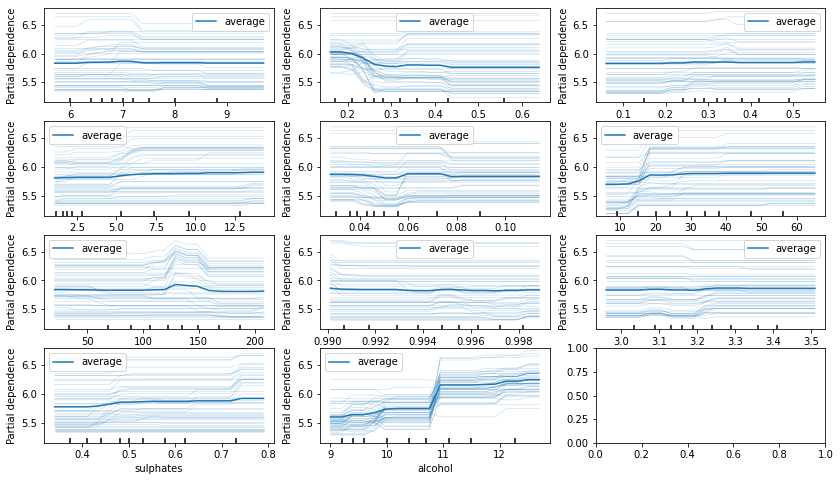

In [9]:
import matplotlib.pyplot as plt
from sklearn.inspection import (
    partial_dependence, PartialDependenceDisplay)

fig, ax = plt.subplots(4, 3, figsize=(14, 8))
display = PartialDependenceDisplay.from_estimator(
    rf, X_train, list(rf.feature_names_in_), kind="both",
    subsample=50, n_jobs=3, grid_resolution=20,
    random_state=0, ax=ax.ravel()[:11])

## LIME

Pour résumer, l'approche [LIME](https://interpret.ml/docs/lime.html) consiste à approximer les prédictions d'un modèle compliqué par un modèle plus simple comme un modèle linéaire. Comme le modèle simple ne peut être aussi précis que le modèle compliqué, il est estimé au voisinage de chaque observation dont on cherche à expliquer la prédiction.

In [10]:
import warnings
from interpret import show
from interpret.blackbox import LimeTabular

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    lime = LimeTabular(predict_fn=rf.predict, data=X_train, 
                       feature_names=list(rf.feature_names_in_))
    lime_local = lime.explain_local(X_test[:5], y_test[:5])

show(lime_local)

<!-- http://127.0.0.1:7001/1759166332640/ -->

## Shap

La méthode précédente ne fonctionne pas si les variables sont corrélées. L'idée de [Shap](https://interpret.ml/docs/shap.html?highlight=shap#interpret.blackbox.ShapKernel) est de mesurer ce qu'apporte une variable en apprenant un modèle avec et sans. Ce faisant, il faut le faire sur tous les combinaisons possibles de variables. C'est très long. Voici un algorithme approché tiré de ce [livre](https://christophm.github.io/interpretable-ml-book/shapley.html#estimating-the-shapley-value) :

Approximate Shapley estimation for single feature value:

* Output: Shapley value for the value of the j-th feature
* Required: Number of iterations M, instance of interest x, feature index j, data matrix X, and machine learning model f
* For all m = 1,...,M:
    * Draw random instance z from the data matrix X
    * Choose a random permutation o of the feature values
    * Order instance x: $x_o=(x_{(1)},...,x_{(j)},...,x_{(p)})$
    * Order instance x: $z_o=(z_{(1)},...,z_{(j)},...,z_{(p)})$
    * Construct two new instances:
         * With j: $x_{+j}=(x_{(1)},...,x_{(j-1)},x_{(j)},z_{(j+1)},...,z_{(p)})$
         * Without j: $x_{-j}=(x_{(1)},...,x_{(j-1)},z_{(j)},z_{(j+1)},...,z_{(p)})$
    * Compute marginal contribution $\phi_j^m=f(x_{+j}) - f(x_{-j})$
* Compute Shapley value as the average: $\phi_j(x)=\frac{1}{M} \sum_{m=1}^M \phi_j^m$

In [11]:
from interpret.blackbox import ShapKernel

shap = ShapKernel(predict_fn=rf.predict, data=X_train, 
                  feature_names=list(rf.feature_names_in_))
shap_local = shap.explain_local(X_test[:5], y_test[:5])

X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
Using 1299 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5 [00:00<?, ?it/s]

X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feat

In [12]:
show(shap_local)

<!-- http://127.0.0.1:7001/1759002061216/ -->